In [2]:
!pip install torch
!pip install matplotlib
!pip install torchvision
!pip install cv
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision 
import torchvision.transforms as T 
from PIL import Image
import random
import cv
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
torch.set_default_tensor_type('torch.FloatTensor')

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

img_dir = "Deep Learning Data/face_images" #change to desired dataset directory
out_dir = "Faces" #change to desired output directory
fcm = True #false to avoid creating new image files
rm = True #false to disable the regressor
usm = False #true to use saved pretrained Model
sm = True #false to disable saving model

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print("File creation mode: ",str(fcm))
print("Regressor mode: ", str(rm))
  

Is CUDA supported by this system? True
CUDA version: 11.1


**Create Dataset from Images**
Imports data from Deep Learning Data Folder and stores it as a data structure

In [4]:
def load_images_from_folder(folder, num):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            if fcm:
                ret = cv2.imwrite('%s/Augmented/%05d.jpg' % (out_dir,num), img)
            num += 1
    return images

def print_tensor_to_numpy(tensor):
    tensor_reshape = torch.movedim(tensor, 0, 2)
    npimg = tensor_reshape.numpy()
    plt.imshow(npimg[:, :, :])  

k = 0
data = load_images_from_folder(img_dir, k)
data = np.asarray(data)

for i in range(0,9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.swapaxes(data[i][:,:,:]), 0,2)
    
data = torch.from_numpy(data) #converts numpy matrix to tensor
data = torch.movedim(data, 3, 1) #moves the rgb to the second index
data = data[torch.randperm(data.size()[0])]#randomly shuffles tensor along first dim 

In [ ]:
def labConvHelper(input):
    conv = cv2.cvtColor(input,cv2.COLOR_BGR2LAB)
    return conv

In [ ]:
def convToLab_saveToFile(dataset, saveToFile = False, iter = 0):
    output = []
    outputl = []
    outputa = []
    outputb = []
    for i in range(len(dataset)):
        image = np.asarray(dataset[i,:,:,:])
        image = np.swapaxes(image,1,0)
        image = np.swapaxes(image,1,2)
        imageLAB = labConvHelper(image)
        l,a,b = cv2.split(imageLAB)
        if saveToFile:
            statusL = cv2.imwrite('%s/L/%05d_L.jpg' % (out_dir,iter), l)
            statusa = cv2.imwrite('%s/a/%05d_a.jpg' % (out_dir,iter), a)
            statusb = cv2.imwrite('%s/b/%05d_b.jpg' % (out_dir,iter), b)
        iter += 1
        output.append(imageLAB)
        outputl.append(l)
        outputa.append(a)
        outputb.append(b)
    return np.asarray(output),np.asarray(outputl),np.asarray(outputa),np.asarray(outputb)

Done converting


**Augment Dataset**

In [10]:
def flip_img(tensor, show =False):
    flipped_img = torch.flip(tensor, (2,))
    if show == True:
        print_tensor_to_numpy(flipped_img)
    return flipped_img

def crop_img(tensor, show = False):
    crop = T.RandomCrop((96,96)) # transform for square crop
    resize_crop = T.Resize((128,128)) #resizes image back to original dimension
    cropped_img = resize_crop(crop(tensor)) 
    if show == True:
        print_tensor_to_numpy(cropped_img)
    return cropped_img

def tint_img(tensor, show = False):
    tint_val = 0.1*random.randrange(6, 10)
    tensor[0, :, :] = tint_val*tensor[0, :, :]
    tensor[1, :, :] = tint_val*tensor[1, :, :]
    tensor[2, :, :] = tint_val*tensor[2, :, :]
    tinted_img = tensor[:, :, :]
    if show == True:
        print_tensor_to_numpy(tinted_img)
    return tinted_img

def create_new_img(tensor, show = False):
    chance = random.randrange(0, 10)
    #60% chance of only one transformation
    if (chance < 2):
        new_img = flip_img(tensor) 
    elif (chance >= 2 and chance <4):
        new_img = crop_img(tensor)
    elif (chance >= 4 and chance <6):
        new_img = tint_img(tensor)
    #40% chance of more complex transformations
    elif (chance >= 6 and chance <8):
        tensor_cropped = crop_img(tensor)
        tensor_tinted = tint_img(tensor_cropped)
        new_img = tensor_tinted
    elif (chance >= 8 and chance <=10):
        tensor_flipped = flip_img(tensor) 
        tensor_cropped = crop_img(tensor_flipped)
        tensor_tinted = tint_img(tensor_cropped)
        new_img = tensor_tinted
        
    if show == True:
        print_tensor_to_numpy(new_img)
        
    return new_img

In [14]:
#for loop which appends the newly created images (takes a while)
k = len(data)
for j in range(0, 7): #change this 1 to 7
    for i in range(0, k):
        new_img = create_new_img(data[i, :, :, :])
        new_img = new_img[None, :, :, :] #extending the dimensions so that vector can be appended
        data = torch.cat((data, new_img), 0)
        tmp = new_img.numpy()
        tmp = tmp[0].swapaxes(0,1)
        tmp = tmp.swapaxes(1,2)
        if fcm:
            ret = cv2.imwrite('%s/Augmented/%05d_A.jpg' % (out_dir,k), tmp)
        k += 1
        
print("Done augmenting data...")
imageLab, l, a, b = convToLab_saveToFile(data, fcm, len(data))
imageLab = np.swapaxes(imageLab,2,3)
imageLab = np.swapaxes(imageLab,1,2)
print("Done converting")

Done augmenting data...


**Regressor**

Finds mean chrominance across the entire greyscale image using spatial convolution

In [ ]:
#Prepare data for regression
normData = torch.from_numpy(l).to(torch.float32)
normData = normData.unsqueeze(1)
criterion = nn.MSELoss().to(device)

bs = 32
x_set = l
x_set = x_set[:,np.newaxis,:,:]

x_set = x_set/255
y_set = np.asarray([a,b])
y_set = y_set.swapaxes(0,1)
y_set = np.expand_dims(np.expand_dims(y_set.mean(axis = 2).mean(axis = 2), axis = 2), axis = 2)
norm_ab = y_set/255

vIndex = np.ceil(len(x_set)*0.9)

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_set[0:vIndex]).to(torch.float32), torch.from_numpy(norm_ab[0:vIndex]).to(torch.float32))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=bs, 
                                        shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_set[vIndex:]).to(torch.float32), torch.from_numpy(norm_ab[vIndex:]).to(torch.float32))
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                        batch_size=bs,
                                        shuffle=True)

In [16]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size=3, stride = 2, padding = 1)
        self.c1bn = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size=3, stride = 2, padding = 1)
        self.c2bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size=3, stride = 2, padding = 1)
        self.c3bn = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size=3, stride = 2, padding = 1)
        self.c4bn = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size=3, stride = 2, padding = 1)
        self.c5bn = nn.BatchNorm2d(8)
        self.conv6 = nn.Conv2d(in_channels = 8, out_channels = 4, kernel_size=3, stride = 2, padding = 1)
        self.c6bn = nn.BatchNorm2d(4)
        self.conv7 = nn.Conv2d(in_channels = 4, out_channels = 2, kernel_size=3, stride = 2, padding = 1)
        self.c7bn = nn.BatchNorm2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.c1bn(x))
        x = self.conv2(x)
        x = F.relu(self.c2bn(x))
        x = self.conv3(x)
        x = F.relu(self.c3bn(x))
        x = self.conv4(x)
        x = F.relu(self.c4bn(x))
        x = self.conv5(x)
        x = F.relu(self.c5bn(x))
        x = self.conv6(x)
        x = F.relu(self.c6bn(x))
        x = self.conv7(x)
        x = F.relu(self.c7bn(x))
        return x
        
if rm:
    model = NN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    for epoch in range(10):
        model.train()
        loss = 0 
        for i, (L_data, ab_data) in enumerate(train_loader):
            model.train()
            L_data = L_data.to(device)
            ab_data = ab_data.to(device)
            optimizer.zero_grad()
            outputs = model(L_data).to(device)
            loss = criterion(outputs, ab_data)
            loss.backward()
            optimizer.step()
        model.eval()
        runningloss = 0
        for j, (vL_data, vab_data) in enumerate(validation_loader):
            vL_data = vL_data.to(device)
            vab_data = vab_data.to(device)
            voutputs = model(vL_data).to(device)
            vloss = criterion(voutputs, vab_data)
            runningloss += vloss.item()
        vloss = runningloss/(j+1)
        print ('Epoch [{}/{}], Training Loss: {}, Validation Loss: {}'.format(epoch+1, 10 ,loss.item(), vloss))
    

Epoch [1/10], Loss: 0.1258699744939804
Epoch [2/10], Loss: 0.06642287224531174
Epoch [3/10], Loss: 0.023487789556384087
Epoch [4/10], Loss: 0.004847357515245676
Epoch [5/10], Loss: 0.0004861270426772535
Epoch [6/10], Loss: 0.00015277575585059822
Epoch [7/10], Loss: 0.00017913623014464974
Epoch [8/10], Loss: 0.00021618796745315194
Epoch [9/10], Loss: 0.0002034121280303225
Epoch [10/10], Loss: 0.00016038681496866047


In [ ]:
#Use Regressor
if rm:
    model.eval()
    indata = torch.from_numpy(np.expand_dims(x_set[128],axis = 0))
    outReg = model(torch.from_numpy()).to(device)
    print("Results of regression: ", np.squeeze(outReg.detach().cpu().clone().numpy()))

**Colorizer**

This is built on the previous regressor with extra upscaling and convolution layers in between.

Epoch [1/100], Loss: 0.0098704993724823
Epoch [2/100], Loss: 0.007203143090009689
Epoch [3/100], Loss: 0.005957709159702063
Epoch [4/100], Loss: 0.0052608647383749485
Epoch [5/100], Loss: 0.004583845846354961
Epoch [6/100], Loss: 0.004117573145776987
Epoch [7/100], Loss: 0.003384217619895935
Epoch [8/100], Loss: 0.0030395665671676397
Epoch [9/100], Loss: 0.0027260195929557085
Epoch [10/100], Loss: 0.0024045498576015234
Epoch [11/100], Loss: 0.002199344104155898
Epoch [12/100], Loss: 0.0019797810819000006
Epoch [13/100], Loss: 0.0019380273297429085
Epoch [14/100], Loss: 0.0017446468118578196
Epoch [15/100], Loss: 0.0015116700669750571
Epoch [16/100], Loss: 0.00147909892257303
Epoch [17/100], Loss: 0.0012927117059007287
Epoch [18/100], Loss: 0.0012600347399711609
Epoch [19/100], Loss: 0.0012293544132262468
Epoch [20/100], Loss: 0.0011032813927158713
Epoch [21/100], Loss: 0.0010963239474222064
Epoch [22/100], Loss: 0.0010971793672069907
Epoch [23/100], Loss: 0.0009900419972836971
Epoch [2

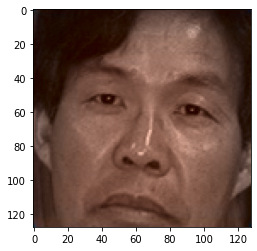

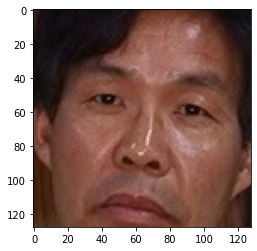

In [21]:
#Model, training, and validation for the colorizer
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size=3, stride = 2, padding = 1)
        self.c1bn = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size=3, stride = 2, padding = 1)
        self.c2bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size=3, stride = 2, padding = 1)
        self.c3bn = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size=3, stride = 2, padding = 1)
        self.c4bn = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size=3, stride = 2, padding = 1)
        self.c5bn = nn.BatchNorm2d(8)
        self.conv6 = nn.Conv2d(in_channels = 8, out_channels = 4, kernel_size=3, stride = 2, padding = 1)
        self.c6bn = nn.BatchNorm2d(4)
        self.conv7 = nn.Conv2d(in_channels = 4, out_channels = 2, kernel_size=3, stride = 2, padding = 1)
        self.c7bn = nn.BatchNorm2d(2)
        self.u1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u5 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u6 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u7 = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv8 = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv9 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv10 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv12 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv13 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv14 = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3, stride = 1, padding = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.c1bn(x))
        x = self.conv2(x)
        x = F.relu(self.c2bn(x))
        x = self.conv3(x)
        x = F.relu(self.c3bn(x))
        x = self.conv4(x)
        x = F.relu(self.c4bn(x))
        x = self.conv5(x)
        x = F.relu(self.c5bn(x))
        x = self.conv6(x)
        x = F.relu(self.c6bn(x))
        x = self.conv7(x)
        x = F.relu(self.c7bn(x))
        x = self.u1(x)
        x = self.conv8(x)
        x = self.u2(x)
        x = self.conv9(x)
        x = self.u3(x)
        x = self.conv10(x)
        x = self.u4(x)
        x = self.conv11(x)
        x = self.u5(x)
        x = self.conv12(x)
        x = self.u6(x)
        x = self.conv13(x)
        x = self.u7(x)
        x = self.conv14(x)
        return x
        
if not usm:
    model = NN().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    for epoch in range(100):
        model.train() 
        tempO = 0
        for i, (L_data, ab_data) in enumerate(train_loader):
            L_data = L_data.to(device)
            ab_data = ab_data.to(device)
            optimizer.zero_grad()
            outputs = model(L_data).to(device)
            loss = criterion(outputs, ab_data)
            loss.backward()
            optimizer.step()
        model.eval()
        runningloss = 0
        for j, (vL_data, vab_data) in enumerate(validation_loader):
            vL_data = vL_data.to(device)
            vab_data = vab_data.to(device)
            voutputs = model(vL_data).to(device)
            vloss = criterion(voutputs, vab_data)
            runningloss += vloss.item()
        vloss = runningloss/(j+1)
        print ('Epoch [{}/{}], Training Loss: {}, Validation Loss: {}'.format(epoch+1, 10 ,loss.item(), vloss))   

In [ ]:
#Save the model
if (not usm) and sm:
    torch.save(model.state_dict(), "Saved Model")

In [ ]:
#Testing Model
if not usm:
    tmpx = torch.from_numpy(np.expand_dims(x_set[128],axis=0)).to(torch.float32).to(device)
    model.eval()

    out = np.expand_dims(model(tmpx).detach().cpu().clone().numpy(), axis = 0)
    tmp = np.concatenate((tmpx.detach().cpu().clone().numpy()*100, out[128]*255-128), axis = 1)
    pred = tmp[0]
    known = imageLab[0]
else:
    model = NN()
    model.load_state_dict(torch.load("Saved Model"))
    model.eval()
    
    inDat = labConvHelper(cv2.imread("Deep Learning Data/Gray/Apple1.jpg"))
    tmpx, tmpa, tmpb= inDat.split()
    
    tmpx = torch.from_numpy(tmpx[:,np.newaxis,:,:]/255).to(device)

    out = out = np.expand_dims(model(tmpx).detach().cpu().clone().numpy(), axis = 0)
    tmp = np.concatenate((tmpx.detach().cpu().clone().numpy()*100, out[0]*255-128), axis = 1)
    pred = tmp[0]
    known = inDat

tmpN = np.swapaxes(pred,0,1)
tmpN = np.swapaxes(tmpN,1,2)
tmp2 = np.swapaxes(known,0,1)
tmp2 = np.swapaxes(tmp2,1,2)
tmpN = (np.round(tmpN))

im = cv2.cvtColor(tmpN,cv2.COLOR_Lab2BGR)
im2 = cv2.cvtColor(tmp2, cv2.COLOR_Lab2BGR)

plt.figure()
plt.title("Predicted Image")
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))
plt.figure()
plt.title("Actual Image")
plt.imshow(cv2.cvtColor(im2,cv2.COLOR_BGR2RGB))